# Quality Assessment
Now it's your turn. Follow [the steps on the platform](https://platform.wbscodingschool.com/courses/data-science/9474/) and use what you've learnt to see how reliable the data is.

In [1]:
import pandas as pd

Load our cleaned DataFrames

In [65]:
orders_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226904 entries, 0 to 226903
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      226904 non-null  int64         
 1   created_date  226904 non-null  datetime64[ns]
 2   total_paid    226904 non-null  float64       
 3   state         226904 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.9+ MB


In [2]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
#orders_cl = pd.read_csv(path)
orders_cl = pd.read_csv(path, parse_dates=['created_date'])

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [5]:
pd.get_option("display.max_rows")

1000

In [7]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

In [6]:
"%.2f" % 2.98765

'2.99'

## 2.&nbsp; Exclude unwanted orders

### Include only acual purchases
No `shopping cart`, `cancelled` etc...

Let's create a copy of the `orders_cl` DataFrame, to make sure any of our changes won't affect the original DataFrame.

In [8]:
actual_purchases_df = orders_cl.copy()

In [13]:
actual_purchases_df.head()

,order_id,created_date,total_paid,state
0,241319,2017-01-02 13:35:40,44.99,Cancelled
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
4,243784,2017-11-24 13:35:19,157.86,Cancelled


Let's look at the make up of `state`.

In [10]:
actual_purchases_df.state.value_counts()

Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: state, dtype: int64

Seems like an ovewhelming amount of the orders are left in the shopping basket - something we'll have to analyse another time. For this task we're interested in only `completed` orders, so let's filter our DataFrame.

In [14]:
actual_purchases_df = actual_purchases_df.loc[actual_purchases_df.state == "Completed", :]

In [ ]:
# alternative option
#rows_to_drop = ['Cancelled', 'Pending', 'Shopping Basket','Place Order']
#actual_orders = orders_cl[~orders_cl['state'].isin(rows_to_drop)]

In [ ]:
# alternative option
#mask = orders_cl['state'].isin(['Cancelled', 'Pending', 'Shopping Basket', 'Place Order'])
#actual_orders = orders_cl.drop(orders_cl[mask].index[:])

In [15]:
actual_purchases_df.head()

,order_id,created_date,total_paid,state
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
5,245275,2017-06-28 11:35:37,149.00,Completed
6,245595,2017-01-21 12:52:47,112.97,Completed


Next, we'll make a list of the `order_id`'s of the `Completed` orders.

In [16]:
actual_purchases_list = list(actual_purchases_df["order_id"])

In [ ]:
actual_purchases_list

Now we can filter our cleaned DataFrames to include only the `order_id`'s in the list we just made. We'll also change the DataFrames from `_cl` to `_qu`, so we can distinguish between the data that has been cleaned, and that which has been quality controlled.

In [18]:
orders_qu = orders_cl.loc[orders_cl["order_id"].isin(actual_purchases_list), :].copy()

In [19]:
orderlines_qu = orderlines_cl.loc[orderlines_cl["id_order"].isin(actual_purchases_list), :].copy()

### Keep only the orders that are present in both `orders` and `orderlines`
Let's begin by looking if there's a big difference between the amount of orders present in `orders` and `orderlines`.

In [20]:
len(list(orders_qu.order_id.unique()))

46605

In [21]:
len(list(orderlines_qu.id_order.unique()))

43064

In [22]:
orders_qu.order_id.nunique()

46605

Approximately 3000 difference!!! Let's fix that. We'll perform an inner merge on the two tables using the `order_id` & `id_order`. This will then keep only the `order_id`'s that are present in both tables, which will then help us filter our `_qu` DataFrames once again.

In [23]:
orders_lines_merged_df = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="id_order")

In [25]:
o_ids_in_both_list = list(orders_lines_merged_df["order_id"].unique())

In [24]:
orders_lines_merged_df["order_id"].nunique()

43064

In [26]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(o_ids_in_both_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(o_ids_in_both_list), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [27]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(43064, 43064)

In [ ]:
# alternative option
#len(orders_qu["order_id"].unique()), len(orderlines_qu["id_order"].unique())

## 3.&nbsp; Exclude orders with unknown products
Let's start by making a list of known products.

In [28]:
known_skus_list = list(products_cl["sku"])

Let's have a look to see how many products in our `orderlines_qu` DataFrame are known and how many are unknown.

In [29]:
orderlines_qu.sku.isin(known_skus_list).value_counts()

True     55320
False     1394
Name: sku, dtype: int64

Looks like the vast majority of products are known.

We can't simply delete the rows containing unknown products. We need to remove the entirety of any order that contains an unknown product.

The 1st step is to identify any order that contains an unknown product. Then find the `order_id` of these orders. Finally filter these order numbers out of our `_qu` DataFrames.

In [30]:
orders_with_unknown_products_list = list(orderlines_qu.loc[~orderlines_qu.sku.isin(known_skus_list), "id_order"])

Now we can filter our DataFrame to exclude the `order_id`'s that contain unknown products

In [31]:
orders_qu = orders_qu.loc[~orders_qu["order_id"].isin(orders_with_unknown_products_list), :]
orderlines_qu = orderlines_qu.loc[~orderlines_qu["id_order"].isin(orders_with_unknown_products_list), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`'s.

In [32]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(41701, 41701)

## 4.&nbsp; Explore the revenue from different tables

In [33]:
orderlines_qu_copy = orderlines_qu.copy()

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [34]:
orderlines_qu_copy.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11
15,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14
21,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50


In [35]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]

In [36]:
orderlines_qu_copy.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19
15,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90
21,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50,142.49


#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [37]:
orderlines_qu_group_order_df = orderlines_qu_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()

In [38]:
orderlines_qu_group_order_df

,id_order,unit_price_total
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,105.98
...,...,...
41696,527042,13.99
41697,527070,19.98
41698,527074,19.98
41699,527096,29.97


In [42]:
orders_qu_copy

,order_id,created_date,total_paid,state
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
5,245275,2017-06-28 11:35:37,149.00,Completed
6,245595,2017-01-21 12:52:47,112.97,Completed
...,...,...,...,...
226544,527042,2018-03-14 11:47:50,18.98,Completed
226572,527070,2018-03-14 11:50:48,24.97,Completed
226576,527074,2018-03-14 11:51:42,24.97,Completed
226598,527096,2018-03-14 11:58:40,34.96,Completed


In [44]:
orderlines_qu_copy

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19
15,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14,60.90
21,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50,142.49
...,...,...,...,...,...,...,...,...
215889,1649474,525664,0,1,TUC0207,16.52,2018-03-14 11:45:05,16.52
215906,1649512,527070,0,2,APP0698,9.99,2018-03-14 11:49:01,19.98
215911,1649522,527074,0,2,APP0698,9.99,2018-03-14 11:49:36,19.98
215932,1649565,527096,0,3,APP0698,9.99,2018-03-14 11:54:35,29.97


### What is the average difference between `total_paid` and `unit_price_total`?

In [39]:
orders_qu_copy = orders_qu.copy()

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [40]:
diff_df = orders_qu_copy.merge(orderlines_qu_group_order_df, left_on="order_id", right_on="id_order")

In [41]:
diff_df.head()

,order_id,created_date,total_paid,state,id_order,unit_price_total
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98


In [42]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head()

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99


Now that we know the difference for each order, we can compute the average.

In [43]:
diff_df.difference.mean().round(2)

4.47

### What is the distribution of these differences?

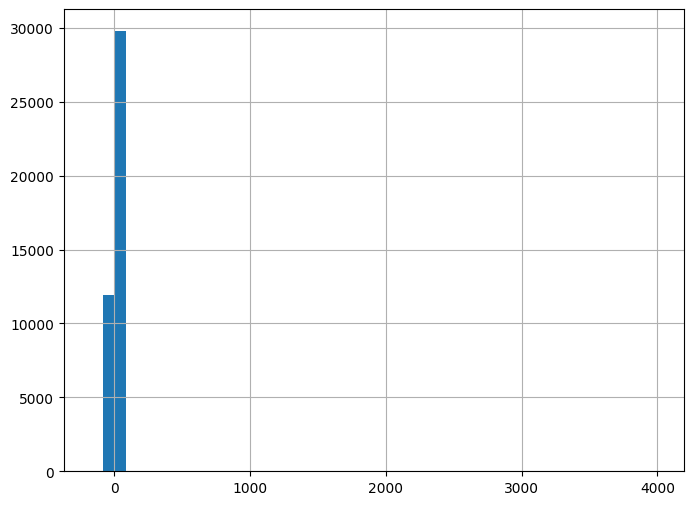

In [44]:
diff_df.difference.hist(bins= 50, figsize=(8,6));

Looking at the spread of the data above, some of the difference must be due to corruption. Let's use `.describe()` to investigate the distribution further.

In [45]:
diff_df.difference.describe()

count   41701.00
mean        4.47
std        26.05
min      -165.00
25%         0.00
50%         4.99
75%         6.99
max      3984.99
Name: difference, dtype: float64

We can see from the our quartiles (0.00, 4.99, 6.99) that most of our data fits an expected pattern - free, 4.99, and 6.99 all seem like reasonable prices to assume as postage. However, look at the min and the max values, -165.00 and 3984.99, this can only occur due to corrupted data.

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

What reasons have you come up with to explain the difference?
vouchers?
shipping to Australia?

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything:
+ lower than the 25% quartile - (1.5 x interquartile range), or
+ higher than the 75% quartile + (1.5 x interquartile range)

is an outlier. Let's use this rule to try and exclude any corrupted data.

In [46]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

# calculate the interquartile range
IQR = Q3-Q1

# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[(diff_df["difference"] >= (Q1 - 1.5*IQR)) & (diff_df["difference"] <= (Q3 + 1.5*IQR)), :]

In [50]:
IQR

6.989999999999981

In [47]:
Q1 - 1.5*IQR

-10.484999999999971

In [48]:
Q3 + 1.5*IQR

17.47499999999995

Let's look at the distribution again to see the affect of removing the outliers.

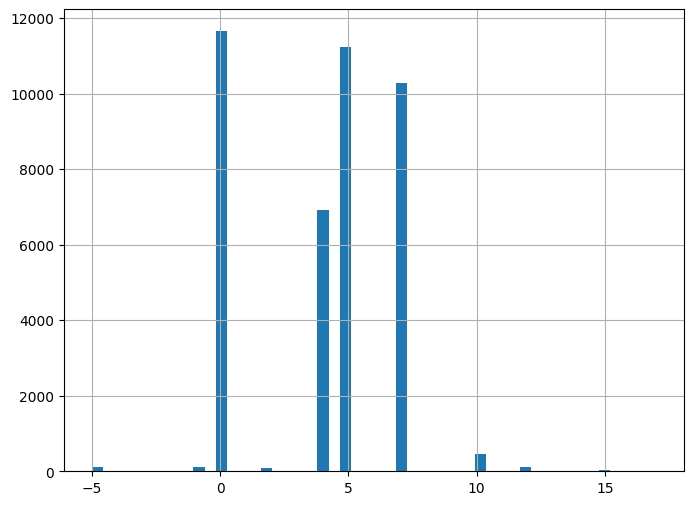

In [49]:
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,6));

This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our `orders_lines_merged` DataFrame.

In [51]:
diff_no_outliers_df.difference.value_counts().sort_values(ascending=False).head(10)

0.00    10476
6.99     4559
4.99     3419
4.99     2523
4.99     2351
6.99     1889
3.99     1882
3.99     1620
3.99     1463
6.99     1305
Name: difference, dtype: int64

In [52]:
diff_no_outliers_df.difference.astype(str).value_counts().sort_values(ascending=False).head(10)

0.0                  10476
6.990000000000009     4559
4.990000000000009     3419
4.990000000000002     2523
4.989999999999995     2351
6.989999999999995     1889
3.990000000000009     1882
3.990000000000002     1620
3.989999999999995     1463
6.990000000000002     1305
Name: difference, dtype: int64

In [53]:
normal_diff_list = list(diff_no_outliers_df["order_id"])

In [54]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_qu["id_order"].isin(normal_diff_list), :]

In [55]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(40985, 40985)

In [56]:
orders_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40985 entries, 1 to 226614
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      40985 non-null  int64         
 1   created_date  40985 non-null  datetime64[ns]
 2   total_paid    40985 non-null  float64       
 3   state         40985 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [58]:
orderlines_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53231 entries, 6 to 215949
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                53231 non-null  int64  
 1   id_order          53231 non-null  int64  
 2   product_id        53231 non-null  int64  
 3   product_quantity  53231 non-null  int64  
 4   sku               53231 non-null  object 
 5   unit_price        53231 non-null  float64
 6   date              53231 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.2+ MB


## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

Let's not forget to download our quality controlled DataFrames

In [ ]:
from google.colab import files

orders_qu.to_csv("orders_qu.csv", index=False)
files.download("orders_qu.csv")

orderlines_qu.to_csv("orderlines_qu.csv", index=False)
files.download("orderlines_qu.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>